In [1]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristics import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def make_plot(metric,test_cost,external_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_cost.keys()),list(test_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_cost)
    ax[1].set_title(metric + ' for external test data')
    plt.show()

def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict,problem):
    
    #'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
    
    if problem == 'PredictRoomBooking':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    elif problem == 'HotelCancellations':
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    elif problem == 'CouponRecommendation':
        columns = []
    elif problem == 'CarSales':
        columns = ['ownercountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandownercountEncoded','fuelcountEncodedandownerMeanEncoded','ownercountEncodedandmaxpowerQuartileMeanEncoded','ownercountEncodedandkmdrivenQuartilecountEncoded','ownercountEncodedandmileageQuartileMeanEncoded','ownercountEncodedandmileageQuartilecountEncoded','fuelcountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandmaxpowerQuartileMeanEncoded','fuelcountEncodedandmaxpowerQuartilecountEncoded','ownercountEncodedandmaxpowerQuartilecountEncoded','sellertypecountEncodedandownerMeanEncoded','fuelcountEncodedandkmdrivenQuartilecountEncoded','sellertypecountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandownercountEncoded','sellertypecountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandmaxpowerQuartilecountEncoded','fuelcountEncodedandsellertypecountEncoded','fuelcountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandkmdrivenQuartilecountEncoded','mileageQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdrivenQuartilecountEncodedandmileageQuartilecountEncoded','kmdrivenQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdriven_Quartile_percentEncoded','maxpower_Quartile_percentEncoded','mileage_Quartile_percentEncoded']
    
    if columns:
        for feature in columns:
            if feature in data_dict['data_external_test'].columns:
                data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
                data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

                for index in data_dict['fold_dict'].keys():
                    data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                    data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
        
    return data_dict

def get_external(data_dict,features,dependent_variable):
    x_external = data_dict['data_external_test'][features]
    y_external = data_dict['data_external_test'][dependent_variable]
    return x_external,y_external

def cost_funct(y_true,y_pred):
    return precision_score(y_true,y_pred)


In [3]:
def calculate_cost(current_at_feature_subset,problem_type,cost_function,data_dict,model,x_validation,y_validation,x_external,y_external):

    test_cost = {}
    external_cost = []
    selected_features = {}
    common_features = []
    
    precision_test = []
    recall_test = []
    precision_external = []
    recall_external = []
    
    #for each fold
    for i in data_dict.keys():
        
        ### - for the set of + features + dataset + model        
        x_train=data_dict[i]['x_train'][current_at_feature_subset]
        y_train=data_dict[i]['y_train']

        x_test=data_dict[i]['x_test'][current_at_feature_subset]
        y_test=data_dict[i]['y_test']
        
        ### do the feature selection process
        model.fit(x_train,y_train)
        
        ### - obtain + filtered features + cost for test + cost for validation
        
        #filtered features
        selected_features[i] = current_at_feature_subset
        
        #predict for test and validation
        y_test_predict=model.predict(x_test)
        y_validation_predict=model.predict(x_validation[current_at_feature_subset])
        
        #predict for external test
        y_external_predict=model.predict(x_external[current_at_feature_subset])
        
        cost1 = cost_function(y_test,y_test_predict)
        cost2 = cost_function(y_validation,y_validation_predict)
        cost3 = cost_function(y_external,y_external_predict)
                
        if problem_type != 'regression':
                        
            precision_test.append(np.mean([precision_score(y_test,y_test_predict),precision_score(y_validation,y_validation_predict)]))
            recall_test.append(np.mean([recall_score(y_test,y_test_predict),recall_score(y_validation,y_validation_predict)]))
            
            precision_external.append(precision_score(y_external,y_external_predict))#
            recall_external.append(recall_score(y_external,y_external_predict))

        #cost for validation and external
        #predict for test and calculate cost function
        test_cost['CV Sample-'+str(i)] = np.mean([cost1,cost2])
        external_cost.append(cost3)
    #also obtain common set of features
    common_features = list(set(selected_features[0]).intersection(set(selected_features[1])).intersection(set(selected_features[2])).intersection(set(selected_features[3])).intersection(set(selected_features[4])))

    print('Total number of input features:',len(current_at_feature_subset),', total number of selected features:',len(common_features))
    
    if problem_type != 'regression':
        print('Combined precision on test and validation data is',np.mean(precision_test),'combined recall on test and validation data is',np.mean(recall_test))
        print('Precision on external test data is',np.mean(precision_external),'recall on external test data is',np.mean(recall_external))
    else:
        print('Combined cost on test and validation data is',np.mean(list(test_cost.values())))
        print('Cost on external test data is',np.mean(external_cost))
    
    return test_cost,external_cost,selected_features,common_features

## Coupon Recommendation

In [4]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'CouponRecommendation'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict,problem)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

x_external_tree,y_external_tree = get_external(data_dict,tree_features_all,dependent_variable)
x_external_linear,y_external_linear = get_external(data_dict,linear_features_all,dependent_variable)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)
data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

## Lightgbm

Total number of input features: 141 , total number of selected features: 141
Combined precision on test and validation data is 0.6992499562767346 combined recall on test and validation data is 0.7244791817149933
Precision on external test data is 0.7449131020882135 recall on external test data is 0.7790697674418605


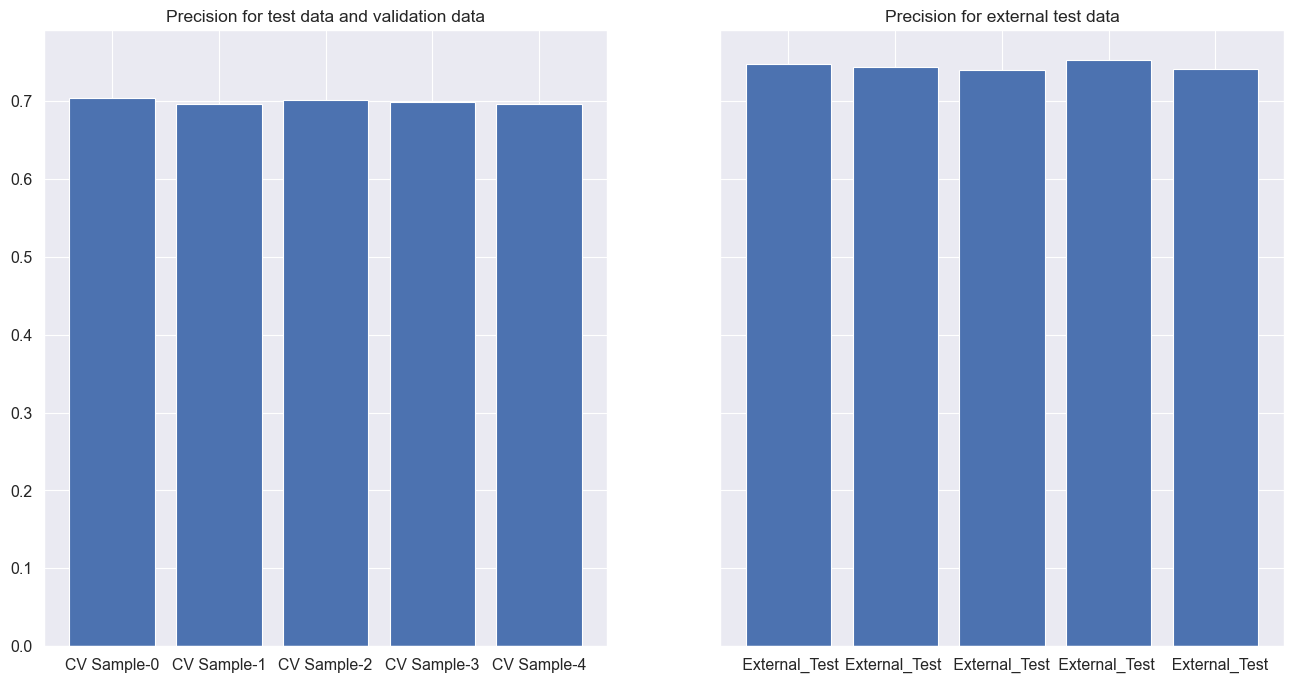

In [5]:
#initialize model
model_use = LGBMClassifier(random_state=1,n_jobs=-1,n_estimators=200)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree)

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Xgboost

Total number of input features: 141 , total number of selected features: 141
Combined precision on test and validation data is 0.7094701943466979 combined recall on test and validation data is 0.7098880146527706
Precision on external test data is 0.7572848609420056 recall on external test data is 0.7399709302325581


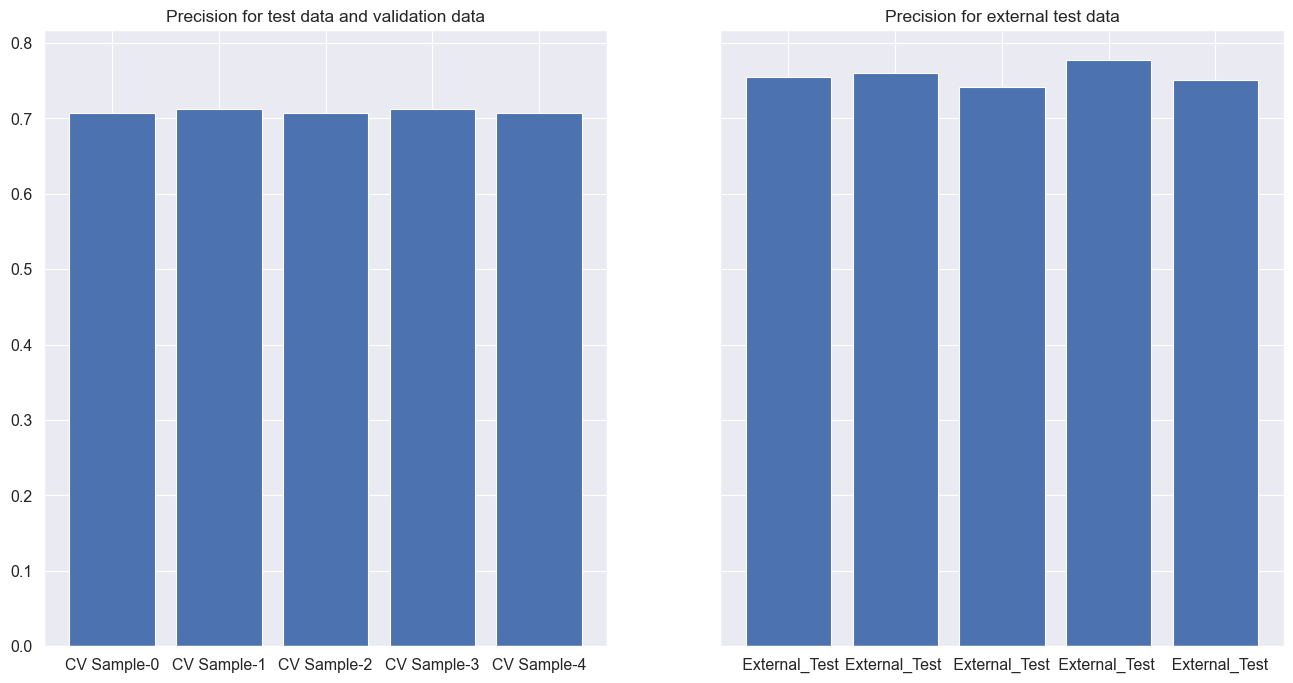

In [6]:
#initialize model
model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree)

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Logistic Regression

Total number of input features: 198 , total number of selected features: 198
Combined precision on test and validation data is 0.6015635691930095 combined recall on test and validation data is 0.7677954287483232
Precision on external test data is 0.6327293522181333 recall on external test data is 0.8123546511627907


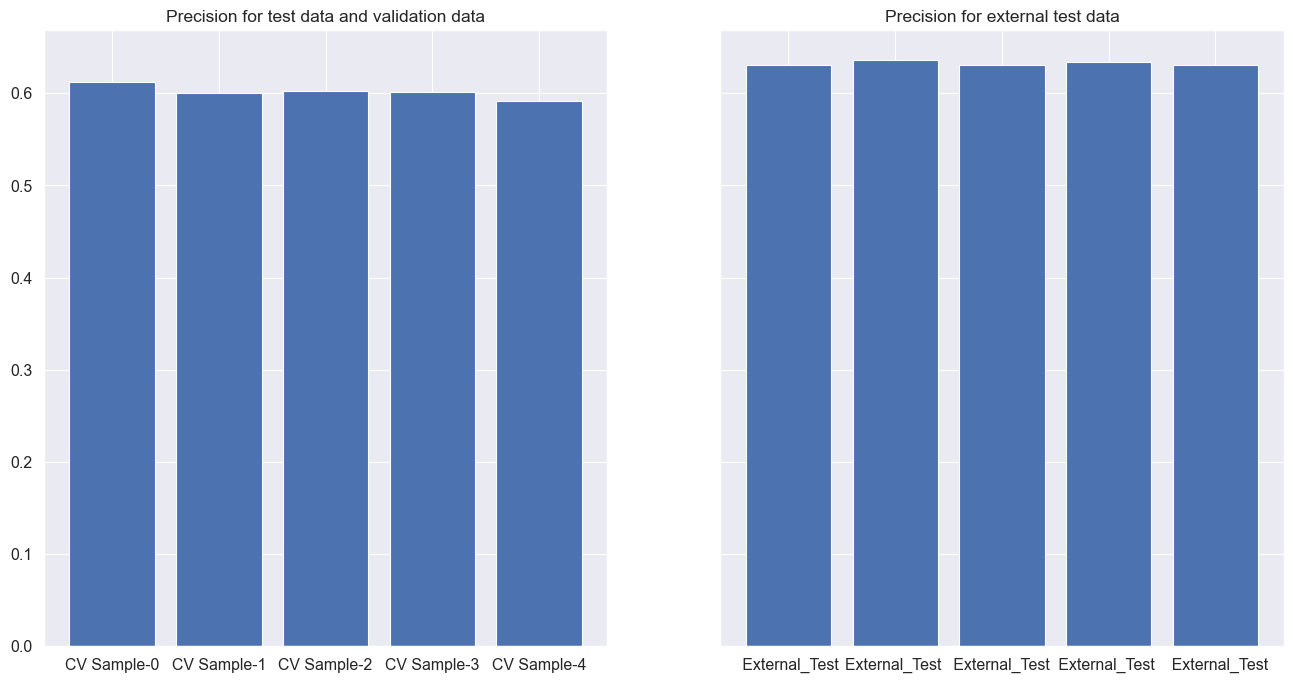

In [7]:
#initialize model
model_use = LogisticRegression(n_jobs=-1)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear)

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)